# TMDB Box Office Prediction EDA + ML

![](https://cdn-images-1.medium.com/max/1200/1*vIR7iO-1GnY2xYxL6NiYkw.png)
[image-source](https://cdn-images-1.medium.com/max/1200/1*vIR7iO-1GnY2xYxL6NiYkw.png)

## Prerequisities

### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

#import warnings
#warnings.filterwarnings("ignore")

['train.csv', 'sample_submission.csv', 'test.csv']


### Loading the data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sub_df = pd.read_csv('../input/sample_submission.csv')

### Inspecting the train set

In [3]:
train_df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

### Check for NA values in trainset

In [5]:
train_df.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

## Exploratory Data Analysis

In [6]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

### Univariate Analysis

#### Revenue

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


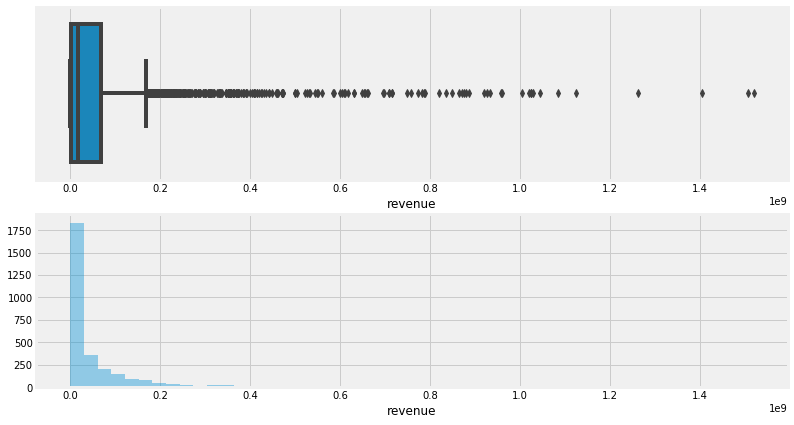

In [7]:
f, ax = plt.subplots(2, figsize=(12,7))
sns.boxplot(x=train_df.revenue, ax = ax[0])
sns.distplot(a=train_df.revenue, kde = False, ax = ax[1])

#### Budget

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


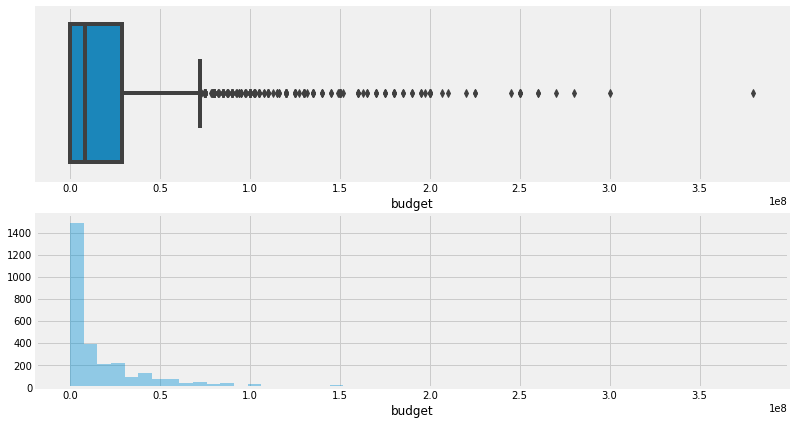

In [8]:
f, ax = plt.subplots(2, figsize=(12,7))
sns.boxplot(x=train_df.budget, ax = ax[0])
sns.distplot(a=train_df.budget, kde = False, ax = ax[1])

#### Genres

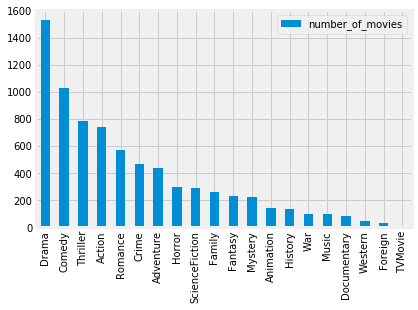

In [9]:

def genres_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace("name", "").replace("id", "").replace(":", "")
    ll = str1.split(",")[1::2]
    return ll

train_df["genres_processed"] = train_df.genres.apply(lambda elem: genres_preprocessing(elem))

genres_dict = dict()

for genre in train_df["genres_processed"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
        else:
            genres_dict[elem] += 1



genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar()

#### Original Language

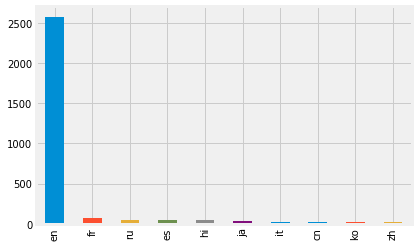

In [10]:
train_df.original_language.value_counts()[:10].plot.bar()

#### Production Companies

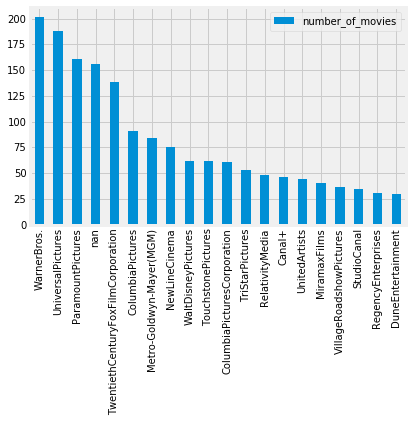

In [11]:
def production_companies_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("id", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_companies_processed"] = train_df.production_companies.apply(lambda elem: production_companies_preprocessing(elem))

production_companies_dict = dict()

for production_company in train_df["production_companies_processed"]:
    for elem in production_company:
        if elem not in production_companies_dict:
            production_companies_dict[elem] = 1
        else:
            production_companies_dict[elem] += 1



production_companies_df = pd.DataFrame.from_dict(production_companies_dict, orient='index')
production_companies_df.columns = ["number_of_movies"]
production_companies_df = production_companies_df.sort_values(by="number_of_movies", ascending=False)
production_companies_df.head(20).plot.bar()

#### production_countries

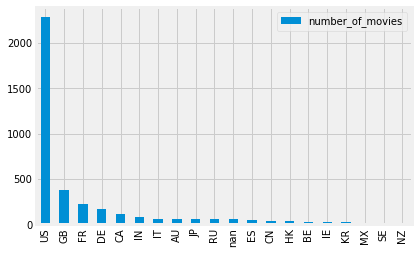

In [21]:
def production_countries_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("iso_3166_1", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_countries_processed"] = train_df.production_countries.apply(lambda elem: production_countries_preprocessing(elem))


production_countries_dict = dict()

for production_country in train_df["production_countries_processed"]:
    for elem in production_country:
        if elem not in production_countries_dict:
            production_countries_dict[elem] = 1
        else:
            production_countries_dict[elem] += 1



production_countries_df = pd.DataFrame.from_dict(production_countries_dict, orient='index')
production_countries_df.columns = ["number_of_movies"]
production_countries_df = production_countries_df.sort_values(by="number_of_movies", ascending=False)
production_countries_df.head(20).plot.bar()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


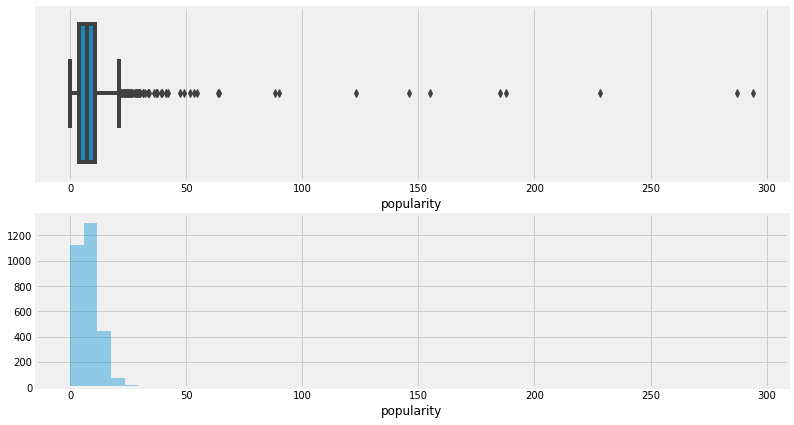

In [23]:
f, ax = plt.subplots(2, figsize=(12,7))
sns.boxplot(x=train_df.popularity, ax = ax[0])
sns.distplot(a=train_df.popularity, kde = False, ax = ax[1])

### Bivariate Analysis

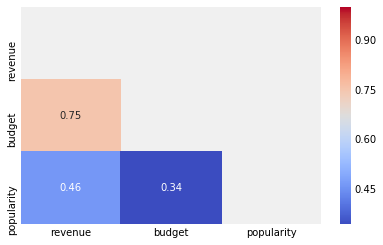

In [26]:
#sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train_df[["revenue", "budget", "popularity"]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

## Machine Learning

### Feature Engineering

In [12]:
train_df['belongs_to_collection_flag'] = [0 if pd.isnull(x) else 1 for x in train_df['belongs_to_collection']]
train_df['belongs_to_collection_flag'].value_counts()

0    2396
1     604
Name: belongs_to_collection_flag, dtype: int64

In [13]:
train_df['homepage_flag'] = [0 if pd.isnull(x) else 1 for x in train_df['homepage']]
train_df['homepage_flag'].value_counts()

0    2054
1     946
Name: homepage_flag, dtype: int64